Importation des library

In [66]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [67]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "1d"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [68]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-03 01:00:00+01:00,3188.36,2996.07,3214.99,2985.58,553669.8146
2025-12-04 01:00:00+01:00,3133.26,3188.39,3240.35,3066.37,486698.3987
2025-12-05 01:00:00+01:00,3021.78,3133.26,3193.33,2983.08,530382.8986
2025-12-06 01:00:00+01:00,3038.06,3021.77,3069.00,3012.58,159721.2488
2025-12-07 01:00:00+01:00,3137.66,3038.06,3150.00,2907.52,321607.8780


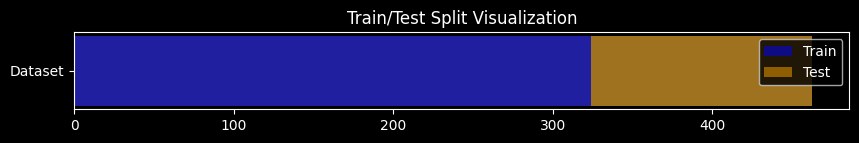

In [69]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [70]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

**La stratégie**

Stratégie : Retour à la moyenne, Long Only
Indicateurs : Bollinger Bands, Filtre de volatilité
Entrée : Prix < BB inférieur
Sortie : Prix > BB supérieur

In [71]:
# Création d'une fonction pour ajouter les indicateurs techniques.
def add_bollinger_bands(df, window=10, std_dev=2):
    df['SMA'] = df['Close'].rolling(window=window).mean()
    # Calcul de la volatilité
    rolling_std = df['Close'].rolling(window=window).std()
    # Calcul des bandes de bollinger
    df['Upper_BB'] = df['SMA'] + (std_dev * rolling_std)
    df['Lower_BB'] = df['SMA'] - (std_dev * rolling_std)
    return df

def add_signal(df):
    # Initialisation à 0
    df['signal'] = 0
    # Signal d'achat
    df.loc[df['Low'] < df['Lower_BB'], 'signal'] = 1
    # Signal de vente
    df.loc[df['High'] > df['Upper_BB'], 'signal'] = -1
    return df

In [72]:
# Ajoute des bblogs et des signaux
df = add_bollinger_bands(df, window=20, std_dev=1.7)
df = add_signal(df)

In [73]:
df.dropna(inplace=True)

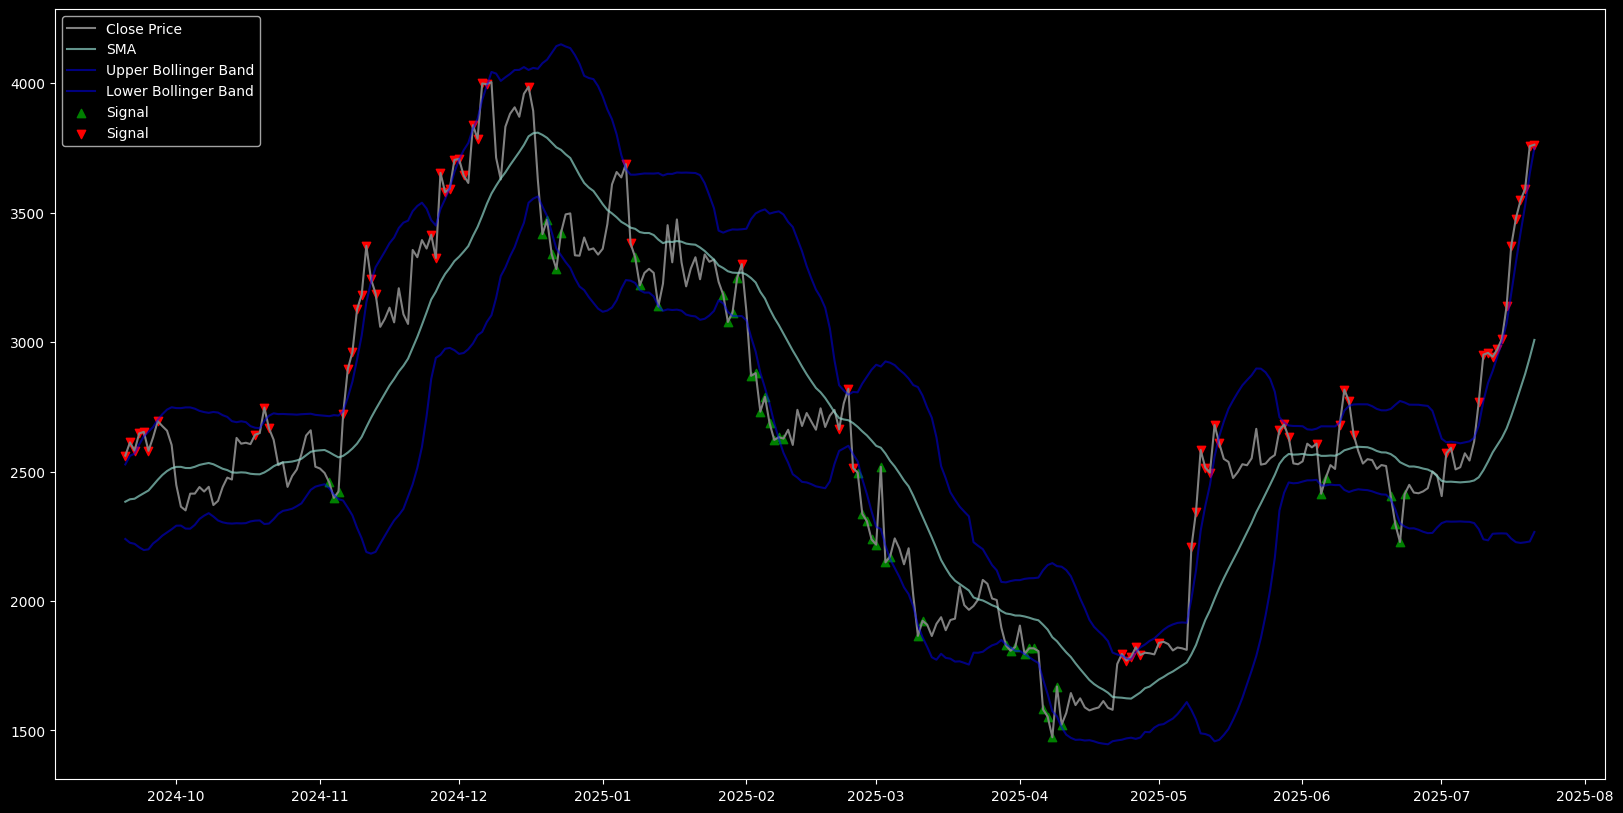

In [74]:
# Afficher les bandes de bollinger & signal (IA)
plt.figure(figsize=(20, 10)) # Change la taille ICI 
plt.plot(df['Close'], label='Close Price', color='grey')
plt.plot(df['SMA'], label='SMA', alpha=0.7)
plt.plot(df['Upper_BB'], label='Upper Bollinger Band', alpha=0.5, color='blue')
plt.plot(df['Lower_BB'], label='Lower Bollinger Band', alpha=0.5, color='blue')
plt.scatter(df[df['signal']==1].index, df[df['signal']==1]['Close'], label='Signal', marker='^', color='green')
plt.scatter(df[df['signal']==-1].index, df[df['signal']==-1]['Close'], label='Signal', marker='v', color='red')
plt.legend()


2.2) Le Filtre de volatilité

In [75]:
def calculate_negative_volatility(df, price_col='Close', window=20):
    # On calcule les variations entre chaque jours
    returns = df[price_col].pct_change()
    # On ne garde que les retours négatifs
    negative_returns = returns.where(returns < 0, 0)
    # On calcule la volatilité des retours négatifs
    downside_vol = negative_returns.rolling(window=window).std()
    return downside_vol

In [76]:
# Calcul de la volatilité_negative
df['neg_vol'] = calculate_negative_volatility(df, price_col='Close', window=10)

# Crée une colonne avec le filtre de volatilité
threshold = 0.025
df.loc[df['neg_vol'] > threshold, 'volat_filter'] = 0
df.loc[df['neg_vol'] <= threshold, 'volat_filter'] = 1

# Applique le filtre de volatilité
df.loc[df['volat_filter'] == 0, 'signal'] = 0

Affichage signal

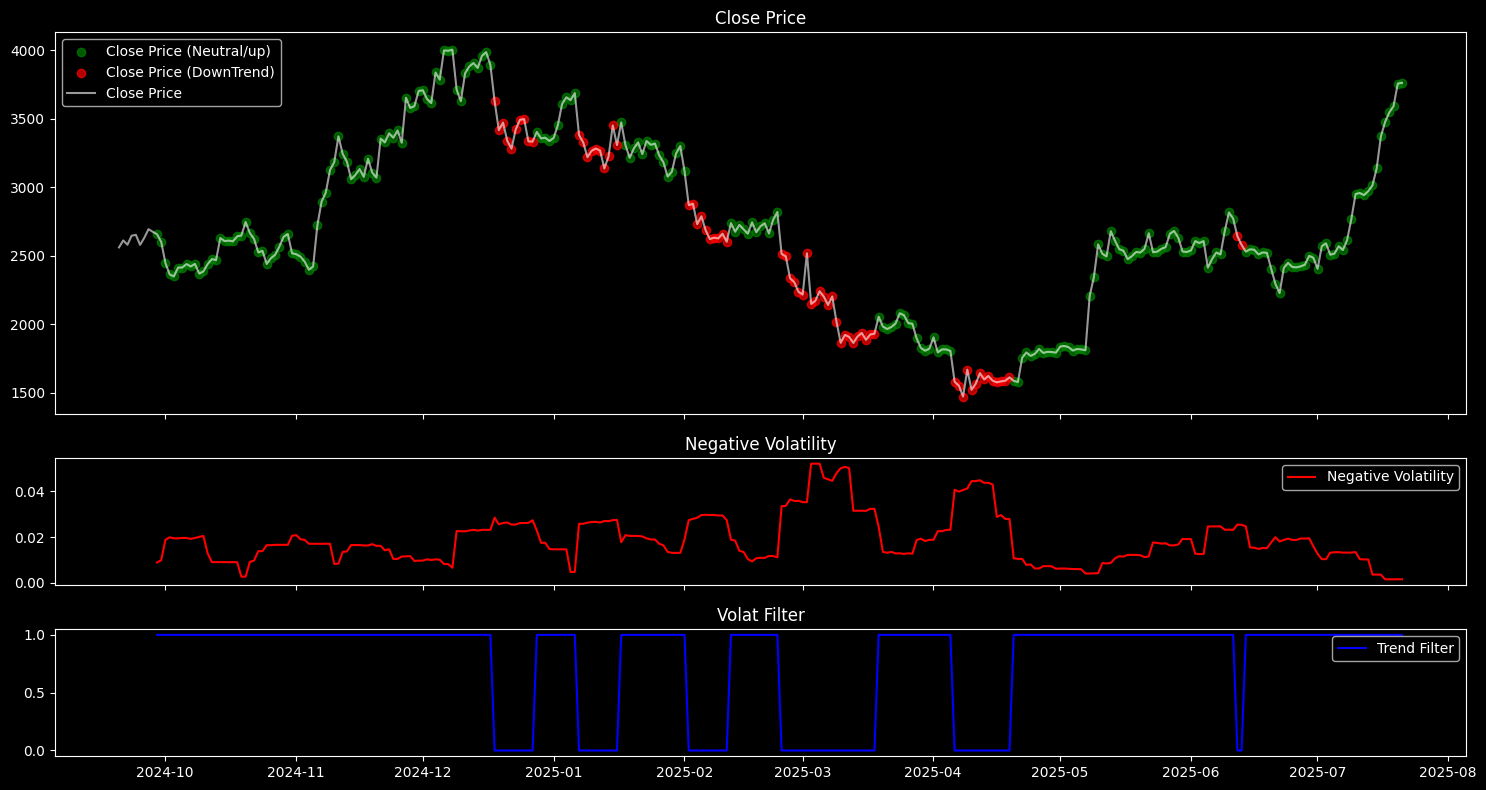

In [77]:
# Create a figure with three subplots sharing x-axis with adjusted height ratios
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,8), sharex=True, height_ratios=[3,1,1])

# Plot Close price on first subplot with colors based on trend filter
ax1.scatter(df[df['volat_filter'] == 1].index, 
           df[df['volat_filter'] == 1]['Close'],
           color='green', label='Close Price (Neutral/up)', alpha=0.7)
ax1.scatter(df[df['volat_filter'] == 0].index,
           df[df['volat_filter'] == 0]['Close'], 
           color='red', label='Close Price (DownTrend)', alpha=0.7)

ax1.plot(df.index, df['Close'], color='white', label='Close Price', alpha=0.6)
ax1.set_title('Close Price')
ax1.legend()

# Plot negative volatility on third subplot
ax2.plot(df.index, df['neg_vol'], label='Negative Volatility', color='red')
ax2.set_title('Negative Volatility')
ax2.legend()

# Plot trend filter on second subplot
ax3.plot(df.index, df['volat_filter'], label='Trend Filter', color='blue')
ax3.set_title('Volat Filter')
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

**Backtest**

Pas de gestion des tailles de position (0 ou 100%)
Une position à la fois
On limite le temps d'un trade à 15 bars/jours (fortement conseillé pour les stratégies MR)

In [78]:
# Crée une colonne position initialisée avec des NaN
df['position'] = np.nan
# Place 1 pour les signaux d'entrée
df.loc[df['signal'] == 1, 'position'] = 1
# Place 0 pour les signaux de sortie
df.loc[df['signal'] == -1, 'position'] = 0

df['position'] = df['position'].ffill()

In [79]:
# Étape 2: Remplir les valeurs NaN restantes avec 0 (avant le premier signal)
df['position'] = df['position'].fillna(0)
# Étape 3: Convertir en type entier
df['position'] = df['position'].astype(int)

In [80]:
#Ajout d'un compteur de durée de détention

def apply_hold_limit_basic(df, max_bars=15):
    # Initialise le compteur à 0
    df['hold_counter'] = 0

    # Itération sur les lignes du DataFrame
    for i in range(1, len(df)):

        # Si la position est 1 (achat)
        if df['position'].iloc[i] == 1:

            # Si la position précédente est déjà 1 on incrémente le compteur
            if df['position'].iloc[i - 1] == 1:
                df.loc[df.index[i], 'hold_counter'] = df['hold_counter'].iloc[i - 1] + 1

            # Si c'est une nouvelle position on initialise le compteur à 1
            else:
                df.loc[df.index[i], 'hold_counter'] = 1

    # Ferme la position si la durée dépasse la limite
    df.loc[df['hold_counter'] >= max_bars, 'position'] = 0
    
    return df

In [81]:
df = apply_hold_limit_basic(df, max_bars=15)

In [82]:
df.head(50)

,Close,Open,High,Low,Volume,SMA,Upper_BB,Lower_BB,signal,neg_vol,volat_filter,position,hold_counter
Open time,,,,,,,,,,,,,
2024-09-20 02:00:00+02:00,2561.40,2465.21,2571.93,2437.31,3.407546e+05,2383.3450,2527.324706,2239.365294,-1,NaN,NaN,0,0
2024-09-21 02:00:00+02:00,2612.40,2561.40,2623.34,2528.97,1.547579e+05,2392.6790,2560.525282,2224.832718,-1,NaN,NaN,0,0
2024-09-22 02:00:00+02:00,2581.00,2612.40,2632.57,2524.58,2.142663e+05,2394.8285,2569.012515,2220.644485,-1,NaN,NaN,0,0
2024-09-23 02:00:00+02:00,2646.97,2580.99,2702.82,2539.49,3.332820e+05,2405.9125,2604.646839,2207.178161,-1,NaN,NaN,0,0
2024-09-24 02:00:00+02:00,2653.20,2646.98,2670.96,2591.56,2.886000e+05,2416.0370,2635.535662,2196.538338,-1,NaN,NaN,0,0
2024-09-25 02:00:00+02:00,2579.95,2653.20,2673.50,2554.05,2.203434e+05,2426.5940,2653.724027,2199.463973,-1,NaN,NaN,0,0
2024-09-26 02:00:00+02:00,2632.26,2580.09,2666.22,2559.20,2.786864e+05,2446.9455,2671.877495,2222.013505,0,NaN,NaN,0,0
2024-09-27 02:00:00+02:00,2694.43,2632.25,2728.60,2615.21,2.818270e+05,2467.9880,2700.349819,2235.626181,-1,NaN,NaN,0,0
2024-09-28 02:00:00+02:00,2675.21,2694.43,2704.35,2650.00,1.372300e+05,2486.8835,2721.416894,2252.350106,0,NaN,NaN,0,0


In [ ]:
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['position']==1,
    exits=df['position']==0,
    sl_stop=0.05,
    #tp_stop=0.05,
    init_cash=50,
    # valeur fixe par trade (60% du capital)
    size_type='percent',
    size=0.6,
    # effet de levier
    
    fees=0.001, #Taker Binance = 0.1%
    slippage=0.001, #aprox
    freq=time
)

stats = portfolio.stats()
# Affichage des statistiques
print(portfolio.stats())
# ajout des statistique dans un csv (les ajouter a la suite et ne pas écraser les données existantes)
stats = portfolio.stats().to_frame().T
stats.to_csv('backtest_stats.csv', mode='a',header=not os.path.exists('backtest_stats.csv'),index=False,)


Start                         2024-09-20 02:00:00+02:00
End                           2025-07-21 02:00:00+02:00
Period                                305 days 00:00:00
Start Value                                        50.0
End Value                                     49.079741
Total Return [%]                              -1.840519
Benchmark Return [%]                          46.885688
Max Gross Exposure [%]                        61.022816
Total Fees Paid                                0.531894
Max Drawdown [%]                               18.15738
Max Drawdown Duration                 111 days 00:00:00
Total Trades                                          9
Total Closed Trades                                   9
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  55.555556
Best Trade [%]                                10.591353
Worst Trade [%]                              -13